Import used libraries

In [1]:
import numpy as np
import pandas as pd
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.io.wavfile import read 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from algorithms import get_features, plot_durations, get_audio, get_trim, pad_audio, remove_noise
import librosa
import os
import math
import time

Indicate audios path and read CSVs to get features for both development and evaluation datasets

In [2]:
# Storing the addresses in corresponding variables
data_path = "dsl_data/development.csv"
evaluation_path = "dsl_data/evaluation.csv"

# Importing development and evaluation data from csv files
df = pd.read_csv(data_path)
evaluation_df = pd.read_csv(evaluation_path)

Analyze Data

In [3]:
# Discover that evaluation data only contains English (United States) and Native speakers
print("Unique values of current language:",evaluation_df['Current language used for work/school'].unique())
print("Unique values of first language:",evaluation_df['First Language spoken'].unique())
print("Unique values of fluency level:",evaluation_df['Self-reported fluency level '].unique())


Unique values of current language: ['English (United States)']
Unique values of first language: ['English (United States)']
Unique values of fluency level: ['native']


Remove data not found in EVALUATION set, rows where first & current language is not English (United States) and fluency is not native

In [4]:
modified_df = df[df['First Language spoken'] == 'English (United States)']
modified_df = modified_df[modified_df['Current language used for work/school'] == 'English (United States)']
modified_df = modified_df[modified_df['Self-reported fluency level '] == 'native']

df = modified_df

Label Encoding (Development & Evaluation)
 
transform categorical data into numerical values since sklearn doesn't accept strings

In [5]:
# Label Encoding

le_mapping = {}
encoding_columns = ['Self-reported fluency level ','First Language spoken','Current language used for work/school','ageRange','gender']

# Encode DEVELOPMENT DATA 
for col in encoding_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Encode EVALUATION DATA TOO
for col, mapping in le_mapping.items():
    evaluation_df[col] = evaluation_df[col].map(mapping)

Label Decoding (if needed)

In [6]:
# Decoding 

# for col, mapping in le_mapping.items():
#     df[col] = df[col].map(mapping)

Combine "action" & "object" in one dataframe column 

In [7]:
df["action-object"] = df['action'].astype(str) +"-"+ df["object"]


Load audio files (.wav)

used to load audio files at specific path and return the waveform as a numpy array data, along with the sample rate

In [8]:
df = df.join(df['path'].apply(get_audio))
evaluation_df = evaluation_df.join(evaluation_df['path'].apply(get_audio))

Trim audio files

reduce the duration of audio files by removing part of each audio signal that contains silence or "noise"

In [9]:
df = df.join(df[['data', 'sample_rate']].apply(get_trim, axis=1))
evaluation_df = evaluation_df.join(evaluation_df[['data', 'sample_rate']].apply(get_trim, axis=1))

# Exract maximum length to use in padding later
max_development = df['duration_trim'].max()
max_evaluation = evaluation_df['duration_trim'].max()
maximum_duration = np.maximum(max_development, max_evaluation)
print(f"Maximum duration in both sets: {maximum_duration}s")
maximum_duration = math.ceil(maximum_duration)
print(f"Ceil maximum duration in both sets: {maximum_duration}s")

Maximum duration in both sets: 10.32126984126984s
Ceil maximum duration in both sets: 11s


Noise reduction in python using spectral gating (noisereduce 2.0.1)


In [10]:
df = df.join(df.apply(lambda x: remove_noise(x['data_trim'], x['sample_rate']), axis=1))
evaluation_df = evaluation_df.join(evaluation_df.apply(lambda x: remove_noise(x['data_trim'], x['sample_rate']), axis=1))

Pad audio files to max audio length in both sets

adds silence (zero values) to the audio signals to make all audio signals same fixed length

In [11]:
df = df.join(df.apply(lambda x: pad_audio(x['data_clean'], x['sample_rate'],maximum_duration), axis=1))
evaluation_df = evaluation_df.join(evaluation_df.apply(lambda x: pad_audio(x['data_clean'], x['sample_rate'],maximum_duration), axis=1))

Extract Features

Apply get_features function to extract features from audio files and trim silence from beggining and end of each audio file
(Done together to reduce complexity)

In [ ]:
df = df.join(df.apply(lambda x: get_features(x['data_clean'], x['sample_rate']), axis=1))
evaluation_df = evaluation_df.join(evaluation_df.apply(lambda x: get_features(x['data_clean'], x['sample_rate']), axis=1))

# # Save extracted features in csv files to avoid repeating steps 
df.to_csv('save_csv/training4.csv')
evaluation_df.to_csv('save_csv/evaluation4.csv')

Get features from previously saved csv files to prevent loading and extracting features again (if needed)

In [14]:
# df = pd.read_csv(r'save_csv/training2.csv').iloc[:,1:]
# evaluation_df = pd.read_csv(r'save_csv/evaluation2.csv').iloc[:,1:]

Select features & labels

In [16]:
x = df.drop(['Id','path','speakerId','action','object','action-object','Self-reported fluency level ','First Language spoken','Current language used for work/school','data', 'sample_rate', 'duration', 'data_trim', 'duration_trim', 'data_pad', 'duration_pad','data_clean'],axis=1)
x_evaluation = evaluation_df.drop(['Id','path','speakerId','Self-reported fluency level ','First Language spoken','Current language used for work/school','data', 'sample_rate', 'duration', 'data_trim', 'duration_trim', 'data_pad', 'duration_pad','data_clean'],axis=1)

y = df[['action-object']].copy()

# Change column names from Int to Str to avoid error by SKLEARN
x.columns = x.columns.astype(str)
x_evaluation.columns = x_evaluation.columns.astype(str)


Drop columns/features (if needed)

In [ ]:
# column_names = [str(i) for i in range(210, 978)]
# x = x.drop(columns=column_names)
# x_evaluation= x_evaluation.drop(columns=column_names)

Transform data: MinMaxScaler

In [17]:
# Apply min-max scaler to make all features between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x) 
X_scaled = scaler.transform(x)
X_evaluation_scaled = scaler.transform(x_evaluation)  

Split data to training and test

In [18]:
#80% training data and 20% test data
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y,test_size = .2,random_state = 42, shuffle = True)

Grid search for Random Forest model

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {'n_estimators': [10, 100, 1000],
              'max_depth': [3, 5, 7],
              'min_samples_leaf': [1, 2, 3],
              'criterion': ['gini', 'entropy']}

# Initialize the random forest classifier
rf = RandomForestClassifier()

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_scaled, y)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


c:\Users\asus rog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\asus rog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\asus rog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\asus rog\AppData\Local

Run Random Forest Classifier after obtaining best hyperparams

In [64]:
#Create a Classifier
# rf_clf=RandomForestClassifier(criterion ='entropy', max_depth= 7, min_samples_leaf= 2, n_estimators= 1000)
rf_clf=RandomForestClassifier()


#Train the model using the training sets 
rf_clf.fit(x_train,np.ravel(y_train))
y_pred_rf=rf_clf.predict(x_test)

# Model Accuracy using test data (20%)
print("Accuracy:",accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf,average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf,average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_rf,average='weighted'))

Accuracy: 0.505863539445629
Precision: 0.5445957763488589
Recall: 0.505863539445629
F1-Score: 0.49714366784487385


Grid search for SVM model

In [ ]:
# # Define the parameter grid to search over

# param_grid = {'C': [0.1,1,4,8,10,50,100,1000], 'gamma': [0.01, 0.1, 1]}

# # Create a SVM with an RBF kernel
# svm = SVC(kernel='rbf')

# # Perform the grid search using 10-fold cross-validation
# grid_search = GridSearchCV(svm, param_grid)
# grid_search.fit(x_train, np.ravel(y_train))

# # Print the best parameters and the corresponding mean test score
# print("Best parameters: ",grid_search.best_params_)
# print("Best score: ",grid_search.best_score_)

Run SVM Classifier after obtaining best hyperparams

In [62]:
svm_clf = svm.SVC(kernel='rbf', C=4,gamma=0.1)

svm_clf.fit(x_train,np.ravel(y_train))
y_pred_svm=svm_clf.predict(x_test)

# Model Accuracy using test data (20%)
print("Accuracy:",accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm,average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm,average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_svm,average='weighted'))

Accuracy: 0.5149253731343284
Precision: 0.547225264497272
Recall: 0.5149253731343284
F1-Score: 0.5108700214705396


Predict labels of evaluation data using SVM

In [63]:
# Build new SVM model to fit all data
svm_clf = svm.SVC()
# svm_clf = svm.SVC(kernel='rbf', C=4,gamma=0.1)
svm_clf.fit(X_scaled,np.ravel(y))

evaluation_svm=svm_clf.predict(X_evaluation_scaled)
evaluation_svm = list(map(lambda s: s.replace("-", ""), evaluation_svm))

svm_df = pd.DataFrame(evaluation_svm, columns = ['Predicted'])
svm_df.index.name = 'Id'

Predict labels of evaluation data using Random Forest

In [ ]:
# Build new SVM model to fit all data

evaluation_rf=rf_clf.predict(X_evaluation_scaled)

evaluation_rf = list(map(lambda s: s.replace("-", ""), evaluation_rf))

rf_df = pd.DataFrame(evaluation_rf, columns = ['Predicted'])
rf_df.index.name = 'Id'


Save both predictions in csv file

In [30]:
# Get current timestamp
now = int(time.time())

# Save evaluation predictions of both models in csv files
svm_df.to_csv(f'evaluation/svm_predictions{now}.csv',index=True,header=True)
# rf_df.to_csv(f'evaluation/rf_predictions{now}.csv',index=True,header=True)

# Print paths of saved csv
print(f'evaluation/svm_predictions{now}.csv')
# print(f'evaluation/rf_predictions{now}.csv')


evaluation/svm_predictions1675278323.csv


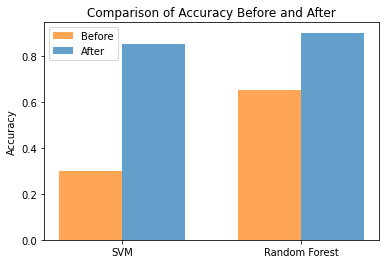

In [58]:
import matplotlib.pyplot as plt
import numpy as np

model1_accuracy = [0.51,0.65]
model2_accuracy = [0.5, 0.90]

models = ['SVM', 'Random Forest']

bar_width = 0.35
bar_x = np.arange(len(models))

plt.bar(bar_x - bar_width/2, model1_accuracy, bar_width, color='#FFA556', align='center')
plt.bar(bar_x + bar_width/2, model2_accuracy, bar_width, color='#629FCA', align='center')

plt.xticks(bar_x, models)
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Before and After')
plt.legend(['Before', 'After'])
plt.show()

